In [1]:
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt

# Simulate Annealing

In [46]:
def objective_fun(x, y):
    return np.sin(x) * np.cos(0.2*y) + 2 * np.sin(0.5*y) * np.cos(0.3*x)

-2.6277491858422986


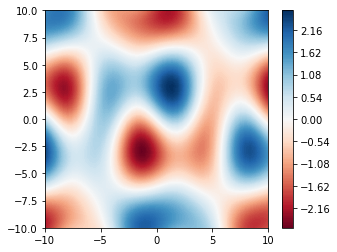

In [47]:
# Visualize target
x = np.linspace(-10, 10, 50)
y = np.linspace(-10, 10, 50)
x, y = np.meshgrid(x, y)
z = objective_fun(x, y)
print(z.min())
fig, ax = plt.subplots(1, 1, figsize=[5, 4])
c = ax.contourf(x, y, z, 200, cmap="RdBu")
fig.colorbar(c);

# 实现

In [54]:
class SimulateAnnealingMinimizer:
    def __init__(
        self,
        objective_fun,
        num_dimensions: int,
        coordinate_range: np.ndarray,
        result_file_path: str,
    ) -> None:
        self._objective_fun = objective_fun
        self._num_dimensions = num_dimensions
        self._coordinate_range = coordinate_range
        self._result_file_path = result_file_path
        if (
            self._coordinate_range.shape[0] != self._num_dimensions
            or self._coordinate_range.shape[1] != 2
        ):
            raise KeyError(
                "The shape of coordinate range should be %s, while a %s array is provided"
                % ((self._num_dimensions, 2), self._coordinate_range.shape)
            )
        # Attribute
        self._box_diag = self._coordinate_range[:, 1] - self._coordinate_range[:, 0]
        self._box_matrix = np.eye(self._num_dimensions) * self._box_diag
        self._box_inv = np.linalg.inv(self._box_matrix)
        self._point_history = np.ones([0, self._num_dimensions + 1])
        self._num_stored_points = 0
        self._accepted_point_history = np.ones([0, self._num_dimensions + 1])
        self._num_accepted_points = 0
        self._cur_beta = 0
        self._cur_point = None

    def generate_point(self, coordinate: np.ndarray) -> np.ndarray:
        is_stored = False
        # Check whether this point is stored
        for i in range(self._num_stored_points):
            if np.all(self._point_history[i, : self._num_dimensions] == coordinate):
                point = self._point_history[i, :]
                is_stored = True
                break
        # Calculate and add unstored point
        if not is_stored:
            value = self._objective_fun(*list(coordinate))
            point = np.ones([1, self._num_dimensions + 1])
            point[0, : self._num_dimensions] = coordinate[:]
            point[0, self._num_dimensions] = value
            self._point_history = np.vstack([self._point_history, point])
            self._num_stored_points += 1
        return point.flatten()

    def random_walk(self, random_probability=0.1) -> np.ndarray:
        is_random = np.random.rand(1)[0] < random_probability
        if is_random:
            new_coordinate = np.random.rand(self._num_dimensions)
            new_coordinate *= self._box_diag
            new_coordinate += self._coordinate_range[:, 0]
        else:
            delta = np.random.rand(self._num_dimensions) - 0.5
            delta *= 2
            new_coordinate = self._cur_point[: self._num_dimensions] + delta
            flag = (new_coordinate < self._coordinate_range[:, 0]) | (
                new_coordinate > self._coordinate_range[:, 1]
            )
            new_coordinate[flag] -= 2 * delta[flag]
        return self.generate_point(new_coordinate)

    def judge(self, delta_energy) -> bool:
        if delta_energy < 0:
            return True
        else:
            threshold = np.exp(-delta_energy / self._cur_beta)
            random_flag = np.random.rand(1)[0]
            return True if random_flag <= threshold else False

    def minimize(self, start_beta, end_beta, decreasing_factor):
        unchanged_iterations = 0
        self._cur_beta = start_beta
        self._cur_point = self.generate_point(np.array([2, 2]))
        while self._cur_beta >= end_beta:
            new_point = self.random_walk()
            delta_energy = (
                new_point[self._num_dimensions] - self._cur_point[self._num_dimensions]
            )
            unchanged_iterations += 1
            if self.judge(delta_energy):
                self._cur_point = new_point.copy()
                self._accepted_point_history = np.vstack(
                    [self._accepted_point_history, self._cur_point.reshape([1, -1])]
                )
                self._num_accepted_points += 1
                unchanged_iterations = 0
                self.save()
            if delta_energy <= 0:
                self._cur_beta *= decreasing_factor
            if unchanged_iterations >= 25:
                break
        print("Final coordinate:", self._cur_point[: self._num_dimensions])
        print("Final value:", self._cur_point[self._num_dimensions])
        print("Total calculation counts: %d" % self._num_stored_points)
        self.save()

    def save(self):
        np.savez(
            self._result_file_path, point_history=self._point_history,
        )

    def load(self):
        data = np.load(self._file_path)
        self._point_history = data["point_history"]
        self._num_stored_points = self._point_history.shape[0]
        print(self._point_history)

    @property
    def point_history(self) -> np.ndarray:
        return self._point_history

    @property
    def accepted_point_history(self) -> np.ndarray:
        return self._accepted_point_history

Final coordinate: [-1.19186878 -2.6382441 ]
Final value: -2.617188587230344
Total calculation counts: 635


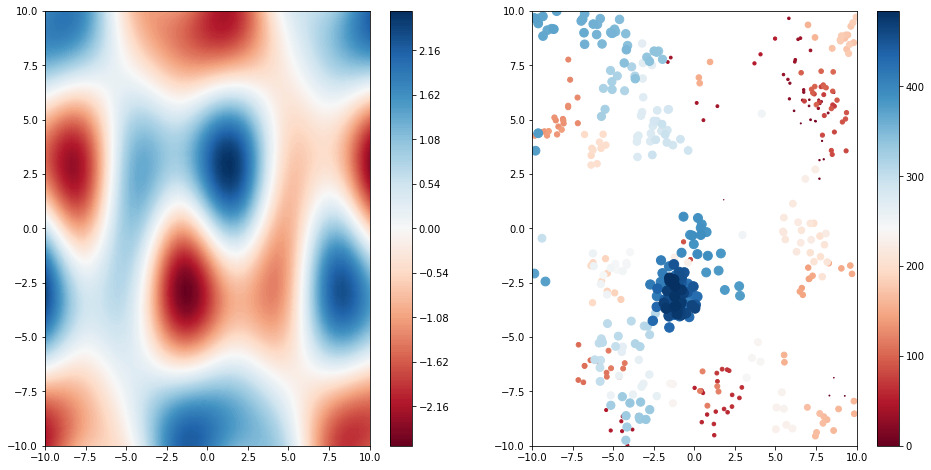

In [56]:
def objective_fun(x, y):
    return np.sin(x) * np.cos(0.2 * y) + 2 * np.sin(0.5 * y) * np.cos(0.3 * x)

res_file = "minimizer.npz"
minimizer = SimulateAnnealingMinimizer(
    objective_fun=objective_fun,
    num_dimensions=2,
    coordinate_range=np.array([[-10, 10], [-10, 10]]),
    result_file_path=res_file,
)
minimizer.minimize(start_beta=1e4, end_beta=1e-4, decreasing_factor=0.95)

x = np.linspace(-10, 10, 50)
y = np.linspace(-10, 10, 50)
x, y = np.meshgrid(x, y)
z = objective_fun(x, y)
fig, ax = plt.subplots(1, 2, figsize=[16, 8])

c = ax[0].contourf(x, y, z, 200, cmap="RdBu")
fig.colorbar(c, ax=ax[0])

point_x = minimizer.accepted_point_history[:, 0]
point_y = minimizer.accepted_point_history[:, 1]
color = np.arange(point_x.shape[0])
size = color / color.max() * 100
c = ax[1].scatter(point_x, point_y, size, c=color, cmap="RdBu")
ax[1].set_xlim(-10, 10)
ax[1].set_ylim(-10, 10)
fig.colorbar(c, ax=ax[1]);

# Dual Annealing optimization

In [9]:
operation = 0
def dump(*x):
    global operation
    global log_file
    with open(log_file, 'a') as f:
        print('Operation %d:' %operation, *x, file=f)
    operation += 1

def objective_fun(args):
    x, y = args
    res = np.sin(x) * np.cos(0.2*y) + 2 * np.sin(0.5*y) * np.cos(0.3*x)
    dump('object_fun %s get result %.3f' %(args, res))
    return res

log_file = 'minimizer.log'
open(log_file, 'w').close()
optimize.dual_annealing(objective_fun, [[-10, 10], [-10, 10]], maxiter=50, callback=dump)

     fun: -2.6423589760080013
 message: ['Maximum number of iteration reached']
    nfev: 231
    nhev: 0
     nit: 50
    njev: 10
  status: 0
 success: True
       x: array([-1.29668358, -2.91217963])

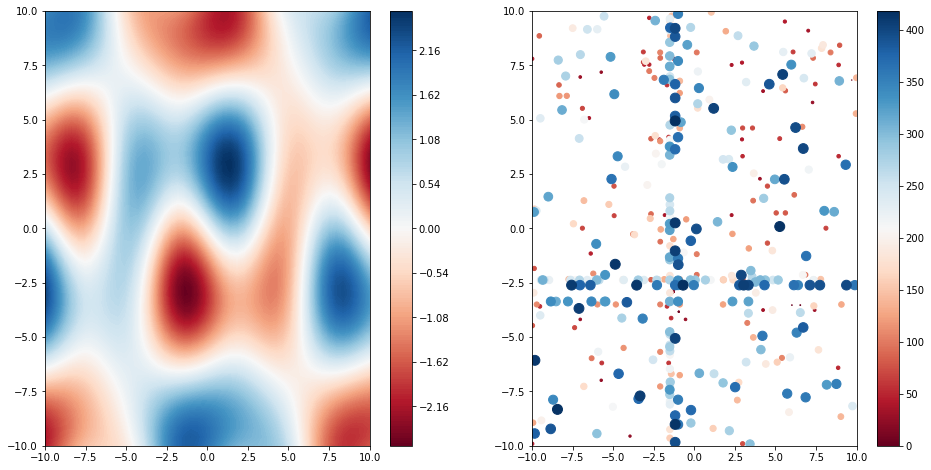

In [8]:
coordinate, result = [], []
with open(log_file, 'r') as f:
    line = f.readline()
    while line:
        if 'object' in line:
            coordinate.append([float(i) for i in line.split('[')[1].split(']')[0].split()])
            result.append(float(line.split('result')[-1].strip()))
        line = f.readline()
coordinate = np.array(coordinate)
result = np.array(result)

def objective_fun(x, y):
    return np.sin(x) * np.cos(0.2 * y) + 2 * np.sin(0.5 * y) * np.cos(0.3 * x)
x = np.linspace(-10, 10, 50)
y = np.linspace(-10, 10, 50)
x, y = np.meshgrid(x, y)
z = objective_fun(x, y)
fig, ax = plt.subplots(1, 2, figsize=[16, 8])

c = ax[0].contourf(x, y, z, 200, cmap="RdBu")
fig.colorbar(c, ax=ax[0])

point_x = coordinate[:, 0]
point_y = coordinate[:, 1]
color = np.arange(point_x.shape[0])
size = color / color.max() * 100
c = ax[1].scatter(point_x, point_y, size, c=color, cmap="RdBu")
ax[1].set_xlim(-10, 10)
ax[1].set_ylim(-10, 10)
fig.colorbar(c, ax=ax[1]);